# Workload forecast: the call center case
### Predicting Winnipeg 311 Incoming Calls By Day

The aim of this project is to create workload predictions for a contact center. Workload predictions allow team managers to better distribute the available resources along time.

For this project I used the 311 Incoming Calls By Day dataset, available [here](https://data.winnipeg.ca/dataset/311-Incoming-Calls-By-Day/p3xc-y6xi).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
from datetime import datetime,timedelta

In [2]:
client = Socrata("data.winnipeg.ca", app_token='l8jySvy0E0EPrmcITztqvizss')
results = client.get("p3xc-y6xi",limit=9999999)

In [3]:
data = pd.DataFrame.from_records(results)
data

,year,month_number,month,day,total_incoming_calls
0,2020,6,Jun,2,14
1,2020,6,Jun,1,2760
2,2020,5,May,31,999
3,2020,5,May,30,1248
4,2020,5,May,29,2121
...,...,...,...,...,...
4256,2008,10,Oct,7,753
4257,2008,10,Oct,6,552
4258,2008,10,Oct,5,4
4259,2008,10,Oct,4,24


In [4]:
data.dtypes

year                    object
month_number            object
month                   object
day                     object
total_incoming_calls    object
dtype: object

Raw data contains:
- day of month
- month (name and number)
- total incoming calls
- year

All data is in `object` type, so converstion needs to be done.

We'll keep only full years (2009-2019) and add features to start exploring data.

In [5]:
data[['day','month_number','total_incoming_calls','year']] = \
    data[['day','month_number','total_incoming_calls','year']].astype('int32')
data = data[(data['year'] > 2008) & (data['year'] < 2020)]
data['date'] = data.apply(lambda x : datetime(x['year'],
                                              x['month_number'],
                                              x['day']),axis=1)

data = data.sort_values('date')
data = data.reset_index(drop=True)

data['day_of_week'] = data['date'].apply(lambda x : x.strftime('%A')[:3])
data['day_of_week'] = pd.Categorical(data['day_of_week'],
                                     ordered=False,categories=['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun'])

data['weekday'] = data['day_of_week'].apply(lambda x : 1 if x in ['Mon', 'Tue','Wed','Thu','Fri'] else 0)

C:\Users\jfpsm\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
data.sort_values('total_incoming_calls').head(20)

,year,month_number,month,day,total_incoming_calls,date,day_of_week,weekday
3838,2019,7,Jul,6,910,2019-07-06,Sat,0
4010,2019,12,Dec,25,953,2019-12-25,Wed,1
3790,2019,5,May,19,1016,2019-05-19,Sun,0
3993,2019,12,Dec,8,1056,2019-12-08,Sun,0
3972,2019,11,Nov,17,1144,2019-11-17,Sun,0
4007,2019,12,Dec,22,1182,2019-12-22,Sun,0
3645,2018,12,Dec,25,1187,2018-12-25,Tue,1
4000,2019,12,Dec,15,1191,2019-12-15,Sun,0
276,2009,10,Oct,4,1195,2009-10-04,Sun,0
4014,2019,12,Dec,29,1198,2019-12-29,Sun,0


Sorting the dataset by `total_incoming_calls` (ascending) we can verify that most of the days are weekend days.
Also on top we can see Christmas days, indicating that if the day is an holiday or not may have influence on the number of incoming calls.

We'll look at the days with the least number of incoming calls not falling on a Saturday or Sunday.

In [7]:
data[~data['day_of_week'].isin(['Sat','Sun'])].sort_values('total_incoming_calls').head(20)

,year,month_number,month,day,total_incoming_calls,date,day_of_week,weekday
4010,2019,12,Dec,25,953,2019-12-25,Wed,1
3645,2018,12,Dec,25,1187,2018-12-25,Tue,1
3280,2017,12,Dec,25,1452,2017-12-25,Mon,1
0,2009,1,Jan,1,1508,2009-01-01,Thu,1
3652,2019,1,Jan,1,1581,2019-01-01,Tue,1
3966,2019,11,Nov,11,1706,2019-11-11,Mon,1
358,2009,12,Dec,25,1733,2009-12-25,Fri,1
4009,2019,12,Dec,24,1776,2019-12-24,Tue,1
3760,2019,4,Apr,19,1787,2019-04-19,Fri,1
284,2009,10,Oct,12,1788,2009-10-12,Mon,1


On top of the list we can see mostly holidays, e.g. Christmas (Dec 25), New Year's Day (Jan 1), Remembrance Day (Nov 11), Good Friday in 2019 (Apr 19). As holidays appear to behave like non-weekdays, we will update the flag `weekday` to reflect holidays as non-weekdays.

In [8]:
def fill_holidays(year):
    # Fixed holidays
    # January 1 (New Year's Day), July 1 (Canada Day), Nov 11 (Remembrance Day) December 25 (Christmas Day)
    holidays = [datetime(year,1,1),datetime(year,7,1),datetime(year,11,11),datetime(year,12,25)]
    
    # Third Monday in February (Louis Riel Day)
    for d in range (15,23):
        if datetime(year,2,d).weekday() == 0:
            holidays.append(datetime(year,2,d))
            break
    
    # Friday before Easter (Good Friday)
    a,b,c = year % 19,year % 4,year % 7
    d = (19 * a + 24) % 30
    e = ((2 * b) + (4 * c) + (6 * d) + 5) % 7   
    if 22 + d + e > 31:
        holidays.append(datetime(year,4,d + e - 9) - timedelta(days=2))
    else:
        holidays.append(datetime(year,3,22 + d + e) - timedelta(days=2))
    
    # Monday before May 25 (Victoria Day)
    for d in range (24,17,-1):
        if datetime(year,5,d).weekday() == 0:
            holidays.append(datetime(year,5,d))
            break
            
    # First Monday in August (Saskatchewan Day)
    for d in range (1,9):
        if datetime(year,8,d).weekday() == 0:
            holidays.append(datetime(year,8,d))
            break    
    
    # First Monday in September (Labour Day)
    for d in range (1,9):
        if datetime(year,9,d).weekday() == 0:
            holidays.append(datetime(year,9,d))
            break
    
    # Second Monday in October (Thanksgiving)
    for d in range (8,15):
        if datetime(year,10,d).weekday() == 0:
            holidays.append(datetime(year,10,d))
            break
            
    return holidays

holidays = []
for year in data['year'].unique():
    holidays.extend(fill_holidays(year))
    
data['weekday'] = data.apply(lambda x : 0 if x['date'] in holidays else x['weekday'],axis=1)

Additionally, we'll create a few metrics reflecting the days prior to the day in analysis:
- average of the previous 7 days
- average of the previous 7 days, including only days of the same category (weekday or weekend)
- average of the previous 28 days
- average of the previous 28 days, including only days of the same category (weekday or weekend)
- average of the last 4 identical weekdays (e.g. last 4 Tuesdays)

In [9]:
for i in range(7,len(data)):
    data.loc[i,'avg_7_day'] = data.loc[i-7:i-1,'total_incoming_calls'].mean()
    
for i in range(7,len(data)):
    data.loc[i,'avg_7_day_week_or_weekend'] = data.loc[i-7:i-1] \
                                             [data.loc[i-7:i-1,'weekday'] == data.loc[i,'weekday']] \
                                             ['total_incoming_calls'].mean()   
    
for i in range(28,len(data)):
    data.loc[i,'avg_28_day'] = data.loc[i-28:i-1,'total_incoming_calls'].mean()

for i in range(28,len(data)):
    data.loc[i,'avg_28_day_week_or_weekend'] = data.loc[i-28:i-1] \
                                             [data.loc[i-28:i-1,'weekday'] == data.loc[i,'weekday']] \
                                             ['total_incoming_calls'].mean()   
    
for i in range(28,len(data)):
    data.loc[i,'avg_last_4_week_days'] = data.loc[i-28:i-1][data['day_of_week'] == data.loc[i,'day_of_week']]['total_incoming_calls'].mean()
    
data = data.dropna()

C:\Users\jfpsm\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Creation of dummy columns for the days of the week:

In [10]:
dow_dummies = pd.get_dummies(data['day_of_week'])
data = pd.concat([data,dow_dummies],axis=1)

Final form of data before training:

In [11]:
data.head()

,year,month_number,month,day,total_incoming_calls,date,day_of_week,weekday,avg_7_day,avg_7_day_week_or_weekend,avg_28_day,avg_28_day_week_or_weekend,avg_last_4_week_days,Mon,Tue,Wed,Thu,Fri,Sat,Sun
28,2009,1,Jan,29,4740,2009-01-29,Thu,1,4091.285714,4544.8,3777.714286,4246.789474,3124.75,0,0,0,1,0,0,0
29,2009,1,Jan,30,4468,2009-01-30,Fri,1,4122.857143,4589.0,3893.142857,4271.450000,4478.50,0,0,0,0,1,0,0
30,2009,1,Jan,31,2920,2009-01-31,Sat,0,4119.000000,2957.5,3934.785714,2947.375000,3129.75,0,0,0,0,0,1,0
31,2009,2,Feb,1,2603,2009-02-01,Sun,0,4094.142857,2870.5,3954.250000,3015.500000,2765.00,0,0,0,0,0,0,1
32,2009,2,Feb,2,4674,2009-02-02,Mon,1,4063.000000,4583.6,3980.321429,4329.750000,4248.00,1,0,0,0,0,0,0


In the cell below, we'll:
- split the dataframe into train (2009-2018) and test (2019)
- train the model
- predict values for 2019 and calculate RMSE (root mean squared error)

In [12]:
features = data.columns.drop(['day','month','month_number','total_incoming_calls','date','day_of_week'])

X_train = data.loc[data['year'] != 2019,features]
y_train = data.loc[data['year'] != 2019,'total_incoming_calls']

X_test = data.loc[data['year'] == 2019,features]
y_test = data.loc[data['year'] == 2019,'total_incoming_calls']

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train)
feat_coef = list(zip(lr.coef_, features))
predictions = lr.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test,predictions))
rmse

274.8218342760793

Calculating the mean absolute deviation:

In [13]:
predict_df = pd.concat([data.loc[data['year'] == 2019,['year','month','month_number','day','total_incoming_calls','day_of_week']]
                        .reset_index(drop=True)
                        ,pd.Series(predictions,name='prediction')],axis=1)
predict_df['diff'] = (predict_df['prediction'] - predict_df['total_incoming_calls']) / predict_df['prediction']
predict_df['abs_diff'] = abs((predict_df['prediction'] - predict_df['total_incoming_calls']) / predict_df['prediction'])
predict_df['abs_diff'].mean()

0.08282380790368311

Deviations frequency (absolute and relative) and histogram:

In [14]:
bins = np.arange(0,60,5)/100
freq = pd.cut(predict_df['abs_diff'], bins)
freq_df = pd.DataFrame({'count':freq.value_counts().sort_index()})
freq_df['%'] = round(freq.value_counts(normalize=True).sort_index(),5)*100
freq_df['cum_%'] = freq_df['%'].cumsum()
freq_df

,count,%,cum_%
"(0.0, 0.05]",143,39.178,39.178
"(0.05, 0.1]",106,29.041,68.219
"(0.1, 0.15]",67,18.356,86.575
"(0.15, 0.2]",30,8.219,94.794
"(0.2, 0.25]",10,2.740,97.534
"(0.25, 0.3]",2,0.548,98.082
"(0.3, 0.35]",2,0.548,98.630
"(0.35, 0.4]",3,0.822,99.452
"(0.4, 0.45]",0,0.000,99.452
"(0.45, 0.5]",1,0.274,99.726


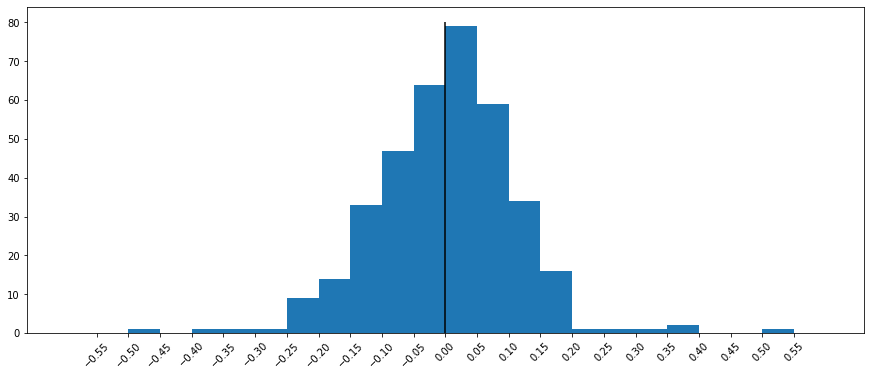

In [15]:
fig = plt.figure(figsize=(15,6))
plt.hist(predict_df['diff'],bins=24,range=(-0.6,0.6))
plt.xticks(np.arange(-55,56,5)/100,rotation=45)
plt.vlines(0,0,80)
plt.show()

Correlation between features:

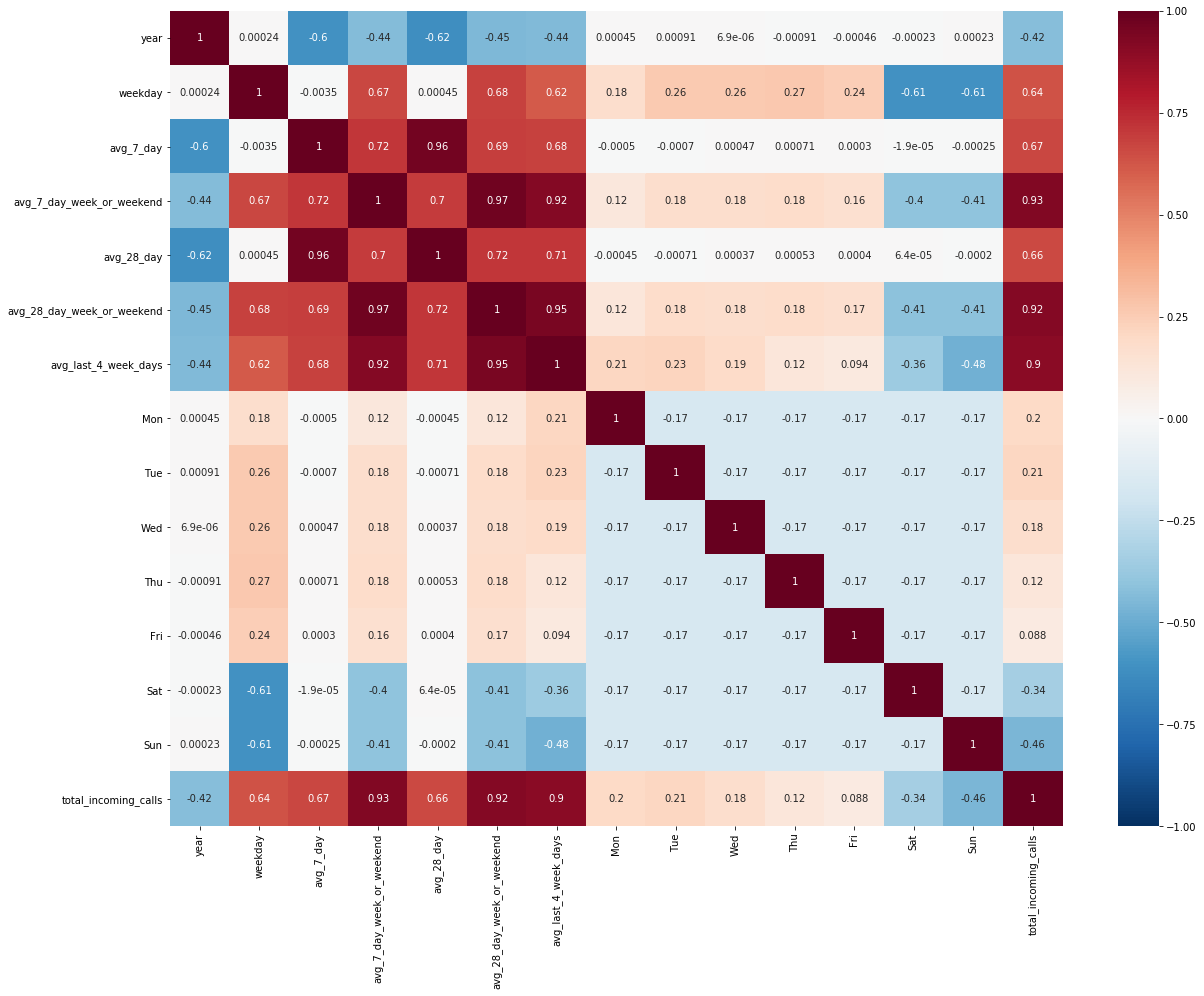

In [16]:
plt.figure(figsize=(20,15))
sns.heatmap(pd.concat([data[features],data['total_incoming_calls']],axis=1).corr(),vmin=-1,vmax=1,cmap='RdBu_r',annot=True)

Plotting the full 2019 year (real vs. forecast):

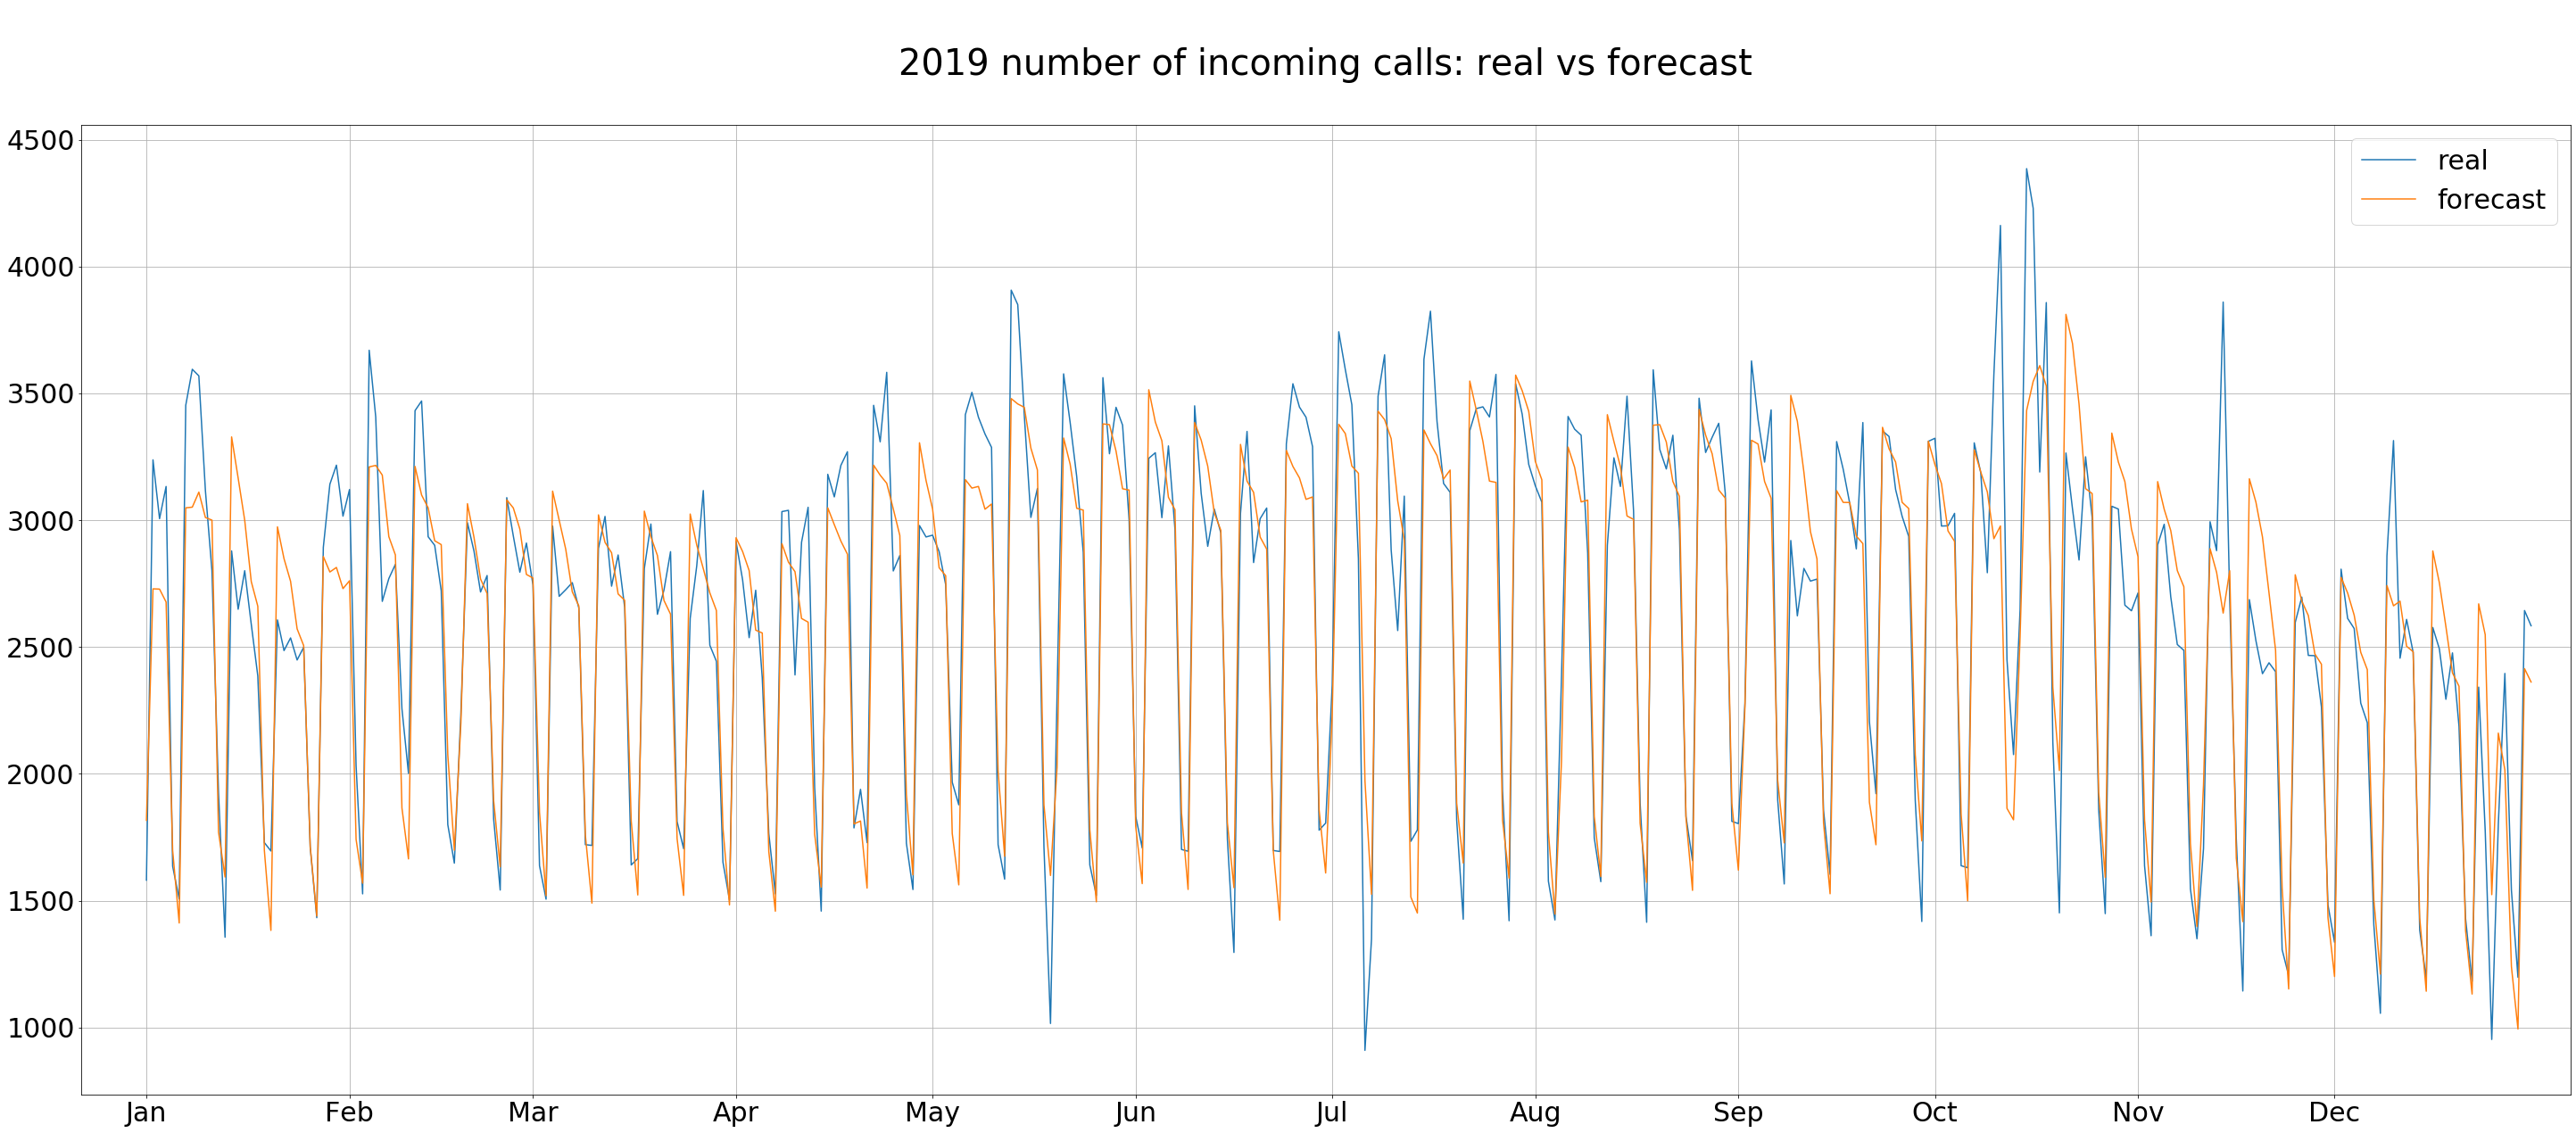

In [17]:
months = predict_df.loc[predict_df['day'] == 1,'month']
fig = plt.figure(figsize=(50,20))
plt.plot(predict_df['total_incoming_calls'],label='real')
plt.plot(predict_df['prediction'],label='forecast')
plt.xticks(ticks=months.index,labels=months.values,fontsize=30)
plt.xlim(-10,370)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)
plt.grid()
plt.title('\n2019 number of incoming calls: real vs forecast\n',{'fontsize':40})
plt.savefig('2019_real_forecast.png')
plt.show()

#### Further work
To improve the tool, further investigation could be done to understand the largest deviations. Considering non-official holidays as holidays (for example Dec 24) could be an improvement to the model

In [18]:
predict_df.sort_values('abs_diff',ascending=False).head(20)

,year,month,month_number,day,total_incoming_calls,day_of_week,prediction,diff,abs_diff
186,2019,Jul,7,6,910,Sat,1972.365638,0.538625,0.538625
317,2019,Nov,11,14,3860,Thu,2633.909580,-0.465502,0.465502
283,2019,Oct,10,11,4162,Fri,2977.253858,-0.397933,0.397933
358,2019,Dec,12,25,953,Wed,1523.832721,0.374603,0.374603
138,2019,May,5,19,1016,Sun,1599.509358,0.364805,0.364805
284,2019,Oct,10,12,2450,Sat,1863.928535,-0.314428,0.314428
357,2019,Dec,12,24,1776,Tue,2548.723147,0.303180,0.303180
292,2019,Oct,10,20,1452,Sun,2012.993909,0.278686,0.278686
287,2019,Oct,10,15,4386,Tue,3432.844345,-0.277658,0.277658
343,2019,Dec,12,10,3314,Tue,2662.492807,-0.244698,0.244698


Interested in discussing this work? Feel free to [email me](mailto:joao@santosmatos.pt).